In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,auc
)
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns

In [6]:
# 1. Load dataset
# wdbc.data does not have headers, so we define them
columns = ["ID", "Diagnosis"] + [f"feature_{i}" for i in range(1, 31)]
data = pd.read_csv("wdbc.data", header=None, names=columns)

In [7]:
# 2. Prepare features and target
X = data.drop(["ID", "Diagnosis"], axis=1)
y = data["Diagnosis"].map({"M": 1, "B": 0})  # Malignant=1, Benign=0

In [8]:

# 4. Preprocessor (scaling not needed for trees, but kept for pipeline consistency)
num_features = X.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[("scale", StandardScaler(), num_features)],
    remainder="drop"
)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", XGBClassifier(
        eval_metric="logloss",   # keep this
        random_state=42
    ))
])

In [11]:
# 6. Hyperparameter grid
param_grid = {
    "clf__n_estimators": [50, 100, 200],
    "clf__learning_rate": [0.01, 0.1, 0.2],
    "clf__max_depth": [3, 5, 7],
    "clf__gamma": [0, 0.1, 0.5],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0],
}

In [12]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring={"accuracy": "accuracy", "f1": "f1_macro"},  # track both
    refit="accuracy",   # choose best by accuracy
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'clf__colsample_bytree': [0.8, 1.0], 'clf__gamma': [0, 0.1, ...], 'clf__learning_rate': [0.01, 0.1, ...], 'clf__max_depth': [3, 5, ...], ...}"
,scoring,"{'accuracy': 'accuracy', 'f1': 'f1_macro'}"
,n_jobs,-1
,refit,'accuracy'
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [13]:
# 5. Extract results into DataFrame
xgb_results = pd.DataFrame(grid.cv_results_)

# 6. Select only required columns
xgb_table = xgb_results[[
    "param_clf__n_estimators",
    "param_clf__learning_rate",
    "param_clf__max_depth",
    "param_clf__gamma",
    "mean_test_accuracy",
    "mean_test_f1"
]]

# 7. Rename for clarity
xgb_table = xgb_table.rename(columns={
    "param_clf__n_estimators": "n_estimators",
    "param_clf__learning_rate": "learning_rate",
    "param_clf__max_depth": "max_depth",
    "param_clf__gamma": "gamma",
    "mean_test_accuracy": "Accuracy",
    "mean_test_f1": "F1 Score"
})

top10 = xgb_table.sort_values(by="Accuracy", ascending=False).head(10)

print("XGBoost Model")
print("Hyperparameter Trials")
print("Table 4: XGBoost - Hyperparameter Tuning (Top 10)")
print(top10[["n_estimators", "learning_rate", "max_depth", "gamma", "Accuracy", "F1 Score"]])



XGBoost Model
Hyperparameter Trials
Table 4: XGBoost - Hyperparameter Tuning (Top 10)
     n_estimators  learning_rate  max_depth  gamma  Accuracy  F1 Score
53            200            0.2          7    0.0  0.975824  0.974103
38            100            0.2          3    0.0  0.971429  0.969321
238           200            0.1          3    0.1  0.971429  0.969288
51            100            0.2          7    0.0  0.971429  0.969347
47            200            0.2          5    0.0  0.971429  0.969406
214           200            0.2          7    0.0  0.971429  0.969202
208           200            0.2          5    0.0  0.971429  0.969202
184           200            0.1          3    0.0  0.971429  0.969288
194           100            0.1          7    0.0  0.969231  0.967212
29            200            0.1          5    0.0  0.969231  0.967184


In [14]:
print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best Parameters: {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.2, 'clf__max_depth': 7, 'clf__n_estimators': 200, 'clf__subsample': 1.0}
Best CV Accuracy: 0.9758241758241759


In [15]:
best_xgb = grid.best_estimator_
y_pred = best_xgb.predict(X_test)

print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 Score:", f1_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_pred))



Test Accuracy: 0.9824561403508771
Test F1 Score: 0.975609756097561
Test Precision: 1.0
Test Recall: 0.9523809523809523
Test ROC AUC: 0.9761904761904762


/tmp/ipykernel_38631/472011034.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp, y=feat_imp.index, palette="viridis")


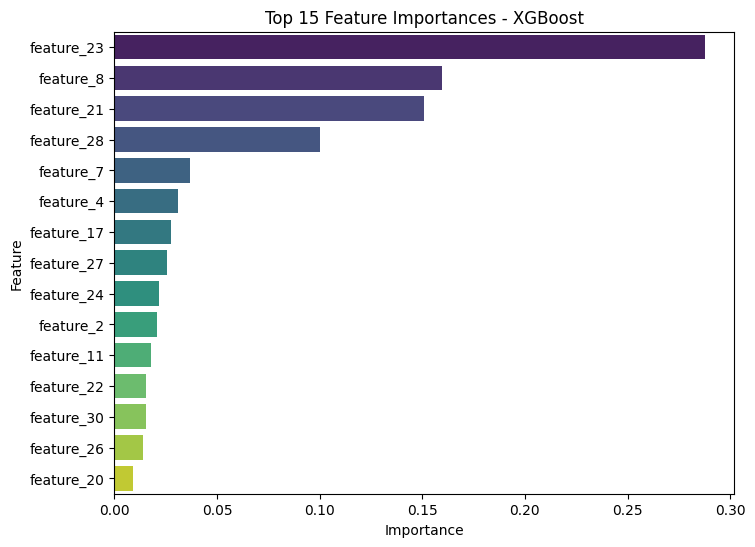

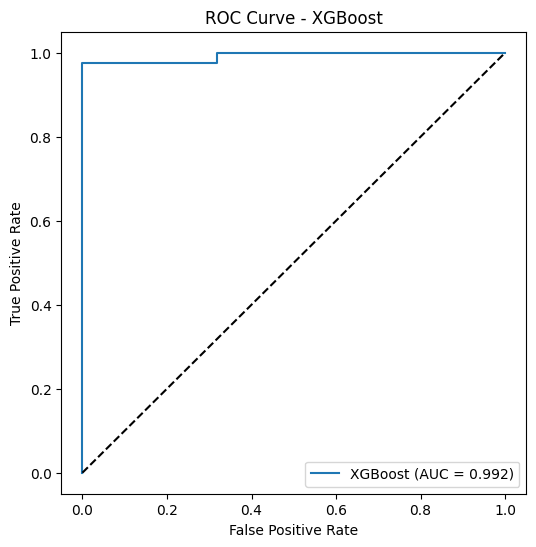

In [16]:
# --- 7. Feature Importances ---
importances = best_xgb.named_steps["clf"].feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)[:15]

plt.figure(figsize=(8,6))
sns.barplot(x=feat_imp, y=feat_imp.index, palette="viridis")
plt.title("Top 15 Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# --- 8. ROC Curve & AUC ---
y_prob = best_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.show()

In [17]:
best_index = grid.best_index_

# Extract fold accuracies for best hyperparameters
best_fold_acc = [grid.cv_results_[f"split{i}_test_accuracy"][best_index] for i in range(grid.cv)]
mean_acc = sum(best_fold_acc) / len(best_fold_acc)

# Get best hyperparameters
best_params = grid.best_params_

# Print results
print("XGBoost - 5 Fold CV Accuracy (Best Hyperparameters)")
for i, acc in enumerate(best_fold_acc, 1):
    print(f"Fold {i}: {acc:.4f}")
print(f"Mean Accuracy: {mean_acc:.4f}")
print(f"Best Hyperparameters: {best_params}")

XGBoost - 5 Fold CV Accuracy (Best Hyperparameters)
Fold 1: 0.9890
Fold 2: 1.0000
Fold 3: 0.9341
Fold 4: 0.9890
Fold 5: 0.9670
Mean Accuracy: 0.9758
Best Hyperparameters: {'clf__colsample_bytree': 0.8, 'clf__gamma': 0, 'clf__learning_rate': 0.2, 'clf__max_depth': 7, 'clf__n_estimators': 200, 'clf__subsample': 1.0}
